**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
  - [Causal Theory a Primer](#toc1_1_)    
- [Methodology and Results](#toc2_)    
  - [Data Generation](#toc2_1_)    
  - [First (naive) strategy: assuming "No hidden confounders"](#toc2_2_)    
  - [Second strategy: keeping into account the latent variable](#toc2_3_)    
    - [Simple Latent Variable Model](#toc2_3_1_)    
      - [Generative Model Specification](#toc2_3_1_1_)    
      - [Variational Inference with SVI](#toc2_3_1_2_)    
      - [Test-Time Inference Model](#toc2_3_1_3_)    
      - [Estimating ATE and ITE](#toc2_3_1_4_)    
        - [A note about the test time inference](#toc2_3_1_4_1_)    
    - [Causal Effect Variational AutoEncoders (CEAVE)](#toc2_3_2_)    
      - [Inference Network (Encoder)](#toc2_3_2_1_)    
      - [Model Network (Decoder)](#toc2_3_2_2_)    
      - [Training Phase](#toc2_3_2_3_)    
      - [Prediction Phase](#toc2_3_2_4_)    
      - [Internal Representation](#toc2_3_2_5_)    
    - [ITE results Linear Dataset](#toc2_3_3_)    
      - [Using non-linear data](#toc2_3_3_1_)    
- [Experiments](#toc3_)    
    - [Setting parameters defaults](#toc3_1_1_)    
      - [Choosing the dataset](#toc3_1_1_1_)    
    - [E1: increasing sample size](#toc3_1_2_)    
    - [E2: increasing correlation among proxies (not through $Z$)](#toc3_1_3_)    
    - [E3: increasing decorellation among proxies (through shuffling)](#toc3_1_4_)    
    - [E4: increasing the latent dimension (of the CEVAE)](#toc3_1_5_)    
    - [E5: prior misspecification](#toc3_1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 

# <a id='toc1_'></a>[Introduction](#toc0_)



We are in the context of an **observational study**: we observe outcomes ($Y$) for available subjects (with many characteristics $X_i$) on the variables of interest ($T$) without control over this variable. This setting poses a problem: there may be lurking variables not taken into account who affect both the treatment and the outcome (i.e., confounders) making the establishment of cause and effect much harder.

This stands in contrast to Randomized Clinical Trials (RCTs), where instead we can randomize the assignment of the subjects to the values of the variable of interest so that no confounders are present.

**Causal Graphical Model (Causal Bayesian Network)**

![image.png](attachment:image.png)

We **observe** the features $X_i$, the treatment $T$ and the outcome $Y$, but we do **not observe** the hidden confounder $Z$!

Our **objective** is to estimate the **Average Treatment Effect** (ATE), i.e., the effect of $T$ on $Y$.

## <a id='toc1_1_'></a>[Causal Theory a Primer](#toc0_)

The term association refers to statistical dependence. Causality is a special kind of association, so causality implies association but not viceversa. 

Let $T$ be the random variable for the treatment, $Y$ the r.v. for the oucome of nterest and X to denote covariates. Assume for example a binary treatment, *i.e.*, $t\in{0,1}$ where $t$ is the realization of $T$.
The **potential outcome** $Y(t)$ denotes what the outcome would be after the treatment $T=t$, i.e., all the possible outcomes after each possible treatment.

In general we consider many individuals in the population of size $n$. We define the **Individual Treatment Effect** (ITE) as:

$$
\tau_i=Y_i(1)-Y_i(0)
$$

The *fundamental problem of causal inference* is that we cannot observe both $Y_i(0)$ and $Y_i(1)$ for the same individual and so neither the ITE. The idea is to use the **Average Treatment Effect** (ATE):

$$
\text{ATE} = \mathbb{E}[Y(1)-Y(0)]
$$

# <a id='toc2_'></a>[Methodology and Results](#toc0_)

## <a id='toc2_1_'></a>[Data Generation](#toc0_)
We generated synthetic data in the following way:

- the hidden confounder is one dimensional with distribution
$$
Z \sim \mathcal{N}(0,1)
$$
- the proxies from which we study the confounder
$$
X_j \sim \mathcal{N}(a_j z,\sigma_X^2)\,,\quad a_j \sim \mathcal{U}_{[-10,10]}
$$
- the treatment and the outcome are
$$
T|Z=z \sim \text{Bernoulli}(\sigma(\beta z))
$$
$$
Y|Z=z,T=t \sim \mathcal{N}(z + t, \sigma_Y^2)

In [1]:
from dowhy import CausalModel
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pyro
from pyro.contrib.cevae import CEVAE
import torch
import matplotlib.pyplot as plt
import logging
from utils import LinearModel,PyroLinearProxyModel,run_experiment,abs_ate_error,rel_ate_error,rmse_ite,plot_three_experiment_results,synthetic_dataset_non_linear,synthetic_dataset_linear
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns


logging.getLogger("pyro").setLevel(logging.DEBUG)
logging.getLogger("pyro").handlers[0].setLevel(logging.DEBUG)

In [2]:
data = synthetic_dataset_linear(n=1000, beta=2.0, num_proxies=10, seed=0)
data.keys()
length_x = len(data["x"][1]) 

#clone
data_original = data.copy()
# translating the dictionary in a dataframe
# I need to change the x matrix in different x columns
for i in range(data["x"].shape[1]):
    data["x_"+str(i)] = data["x"][:,i]

data.pop("x",None)
data.pop("a",None)

data_df = pd.DataFrame.from_dict(data)
data_df.head()

,t,y,z,ite,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,0.0,-1.868301,-1.125840,1.0,-10.419271,-0.488647,7.174606,-4.648432,-4.576821,7.489878,6.996157,-4.095944,0.897944,9.790544
1,0.0,-0.538289,-1.152360,1.0,-9.362418,2.158251,7.738794,-4.534320,-5.552610,6.954226,5.887638,-5.219081,1.483338,11.746528
2,0.0,-3.903064,-0.250579,1.0,-0.370637,-1.324946,1.612699,-1.358586,-0.889863,2.247172,-0.042243,-2.090028,0.893964,2.806923
3,1.0,1.080067,-0.433879,1.0,-3.855381,-1.410040,0.407185,-0.369522,-2.708030,4.276382,1.373499,-4.581057,0.293072,4.355963
4,0.0,1.667862,0.848710,1.0,8.152637,-0.456173,-5.582678,0.746877,3.758286,-4.447976,-5.754533,4.323848,-1.834779,-8.086730


More information and plots about the syntetic generated data can be found in [this notebook](./synthetic_dataset.ipynb).

We can obtain a naive estimate for the ATE by taking the mean of the outcome in the two groups in the dataset (those that received the treatment and those who didn't). We call this estimate "unadgusted" because we are not considering any of the covariates that can affect the treatment effect.

In [3]:
data_1 = data_df[data_df["t"]==1.0]
data_0 = data_df[data_df["t"]==0.0]

print("Unadjusted ATE", np.mean(data_1["y"])- np.mean(data_0["y"]))

Unadjusted ATE 2.1330922


## <a id='toc2_2_'></a>[First (naive) strategy: assuming "No hidden confounders"](#toc0_)

Assuming that there are no hidden confounders (also called **unconfoundness**) means that we consider the $X_i$ to be the only confounders and thus we consider them to be measured!

There exists a simple graphical test, the *back-door criterion*, that can be applied to the causal diagram in order to test if a subset of variables is sufficient to yield an unbiased estimate of the causal effect P(y|do(T=t)).

**Back-door criterion**:
A set of variables X satisfies the criterion relative to an ordered pair of variables $(T,Y)$ in a directed acyclic graph G if:
- no node in X is a descendant of $T$
- X blocks every path from $T$ to $Y$

In this case the set of variables $X_i$ satisfy the back-door criterion and we can apply classical methods for causal inference.

In [4]:
# model = CausalModel(data_df, treatment="t", outcome="y", common_causes="z")
# this would be the real model since we know how the data was generated
# however, in a real setting, we don't usually have access to the real confounders and we consider the proxies variables we have for it instead  

model = CausalModel(data_df, treatment="t", outcome="y", common_causes=["x_"+str(i) for  i in range(0,10)])

![](../images/causal_model_no_hidden_confounder.png)

We identify the **estimand** using the back-door criterion. Again, we remark the need for the unconfoundedness assumption.

The estimand type is **non parametric** because we are **not** assuming any parametric model for the treatment effect.

The other two types of estimand (instrumental variable and front-door criterion) are **not** available because there are no instrumental variables or mediators in the causal graph. 


In [5]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1,U) = P(y|t,x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



We want to compute how the value of $y$ will change with respect to $T$, controlling for all $X_i$.

Since we have obtained a backdoor set we use the **Back-door adjustment**:
If a set of variables X satisfy the back-door criterion relative to (T,Y) then the causal effect of T on Y is identifiable and is given by the formula:
$$p(y|do(t))=\sum_x P(y|t,x)P(x)$$

We can see from this formula that estimating the back-door adjust is thus equivalent to estimate the *conditional probability distribution* $P(y|t,x)$. One of the most common method to do so is to use **linear regression**. 

The linear regression method is useful when the data-generating process for the outcome Y can be approximated as the linear function $Y = \beta_0 + \beta_1 T + \beta_2 X + \varepsilon$. When we fit the linear model we are estimating $\mathbb{\hat E}[Y|T=t,X=x]$.

We then compute the causal effect by marginalizing over all values of x and we use as estimate of the probability of each value $\hat P(x)$ the frequency of that value in the dataset. We obtain:
$$\hat p(y|do(t)) \approx \sum_x \mathbb{\hat E}[Y|T=t,X=x]\hat P(x)$$

In [6]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1,U) = P(y|t,x_0,x_4,x_3,x_8,x_9,x_2,x_6,x_7,x_5,x_1)

## Realized estimand
b: y~t+x_0+x_4+x_3+x_8+x_9+x_2+x_6+x_7+x_5+x_1
Target units: ate

## Estimate
Mean value: 0.8985665542871683
p-value: [4.33652909e-26]



We can also explicitely compute the linear regression using scikit-learn: we verify that the result is the same!

In [11]:
feature_cols = [f'x_{i}' for i in range(10)]
x = data_df[feature_cols]   
t = np.asarray(data_df['t'])
y = data_df['y']

linear_model = LinearModel()
linear_model.fit(x, t, y)          

ite_linear_model = linear_model.ite(x)         
ate_linear_model = ite_linear_model.mean().item()
print("Average Treatment Effect (ATE):", ate_linear_model)


Average Treatment Effect (ATE): 0.8985663056373596


We estimated that receiving the treatment (t=1) increases the outcome of $1.291$ units after adjusting for covariates. This estimates has a very small p-value, suggesting that this effect is statistically significant.

**Remark**: We also verified that, if I give to the model the real hidden confounder (Z), it correctly predicts a causal effect close to 1 for all estimation methods!

## <a id='toc2_3_'></a>[Second strategy: keeping into account the latent variable](#toc0_)

### <a id='toc2_3_1_'></a>[Simple Latent Variable Model](#toc0_)
This is a simple one-dimensional latent variable model implemented in Pyro for estimating the Average Treatment Effect (ATE) and Individual Treatment Effects (ITE).

#### <a id='toc2_3_1_1_'></a>[Generative Model Specification](#toc0_)

For each data point $i=1,\dots,N$:

1. **Prior on the latent**

   $$
   z_i \sim \mathcal{N}(0,\,1).
   $$

2. **Covariate generation**

   $$
   x_i \mid z_i \sim \mathcal{N}(a\,z_i + b,\; \text{diag}(\sigma_x^2)),
   $$

   where:

   * $a, b \in \mathbb{R}^D$
   * $\sigma_x \in \mathbb{R}^D_{>0}$ is a vector of standard deviations.

3. **Treatment assignment**

   $$
   t_i \mid z_i \sim \mathrm{Bernoulli}(\sigma(c\,z_i)),
   $$

   with scalar $c$ controlling how $z$ influences the treatment probability.

4. **Outcome generation**

   $$
   y_i \mid t_i, z_i \sim \mathcal{N}(e\,t_i + f\,z_i,\,\sigma_y^2),
   $$

   where:

   * $e$ is the Average Treatment Effect (ATE) parameter.
   * $f$ is the coefficient for $z$ in the outcome model.
   * $\sigma_y>0$ is the outcome noise standard deviation.

#### <a id='toc2_3_1_2_'></a>[Variational Inference with SVI](#toc0_)

To learn both the generative parameters and approximate the posterior of $z$, we use Stochastic Variational Inference (SVI):

1. **Evidence Lower Bound (ELBO)**

   $$
   \mathcal{L}(\theta, \phi)
   = \mathbb{E}_{q_\phi(z)}[\log p_\theta(x,t,y,z)]
   \;-\;
   \mathrm{KL}\bigl(q_\phi(z)\,\|\,p(z)\bigr).
   $$

   * $\theta$: generative parameters.
   * $\phi$: variational parameters (means and scales of each $z_i$).

2. **Autoguide**
   Pyro’s `AutoDiagonalNormal` constructs a mean-field variational family:

   $$
   q_\phi(z) = \prod_{i=1}^N \mathcal{N}(z_i\mid\mu_i,\sigma_i^2).
   $$

3. **Optimization**

   * Use Adam optimizer over $\theta$ and $\phi$.
   * Each `svi.step(x,t,y)`:

     * Samples $z\sim q_\phi(z)$.
     * Estimates the ELBO via Monte Carlo.
     * Updates both generative and variational parameters via gradients.

4. **Freezing generative parameters**
   After training on (x, t, y), generative parameters are saved and frozen to maintain a fixed model for downstream inference.

#### <a id='toc2_3_1_3_'></a>[Test-Time Inference Model](#toc0_)

To compute potential outcomes and ITEs on new data without observing $y$:

* **`model_xt`**: the same generative process but with no observed $y$.
* **`guide_xt`**: a new `AutoDiagonalNormal` trained by SVI on (x, t) while keeping $\theta$ fixed.


#### <a id='toc2_3_1_4_'></a>[Estimating ATE and ITE](#toc0_)

* **ATE**: The parameter `e` directly represents the average treatment effect:

  $$
  \mathrm{ATE} = e.
  $$

* **ITE**:

  * **On training data** (`ite_train`):

    $$
    \mathrm{ITE}_i
    = 
    \bigl(e + f\,\mathbb{E}[z_i\mid x_i, t_i=1]\bigr)
    -
    \bigl(f\,\mathbb{E}[z_i\mid x_i, t_i=0]\bigr).
    $$
  * **On new data** (`ite`), *i.e.*, at test time:

    1. Instantiate a local guide on $(x_{\text{new}}, t=0)$ and $(x_{\text{new}}, t=1)$.
    2. Perform a few local SVI steps to fit variational means and scales for $N_{\text{new}}$ latents.
    3. Extract mean estimates $\mu^{(0)}, \mu^{(1)}$ and compute

       $$
       \mathrm{ITE}_i
       = \bigl(e + f\,\mu_i^{(1)}\bigr)
       - \bigl(f\,\mu_i^{(0)}\bigr).
       $$

In [8]:
x, t, y, z, ite   = (
    data_original["x"],
    data_original["t"],
    data_original["y"],
    data_original["z"],
    data_original["ite"]
    )

x_train, x_test, t_train, t_test, y_train, y_test, z_train, z_test, ite_train, ite_test = train_test_split(
    x, t, y, z, ite, test_size=0.2, random_state=0
)

In [ ]:
pgm = PyroLinearProxyModel(init_scale=0.1, learning_rate=5e-3, weight_decay=0.0)

losses_pgm = pgm.fit(x_train, t_train, y_train, num_epochs=1000, log_every=100, posterior_epochs=1000)          

ite_pgm = pgm.ite_train(x_train)         
ate_pgm = ite_pgm.mean().item()
# Compute mean squared error between true ITE and computed ITE
true_ite = ite_train
mse_pgm = torch.mean((ite_pgm.flatten() - true_ite.flatten()) ** 2).item()

print("Results for training data")
print("Average Treatment Effect (ATE) (through ITE)", ate_pgm)
print("Estimated ATE fro model coefficients (by def):", pgm.estimate_ate())
print("Mean Squared Error between true ITE and computed ITE:", mse_pgm)
# print(ite)

[SVI] epoch  100 ELBO = 79968.01
[SVI] epoch  200 ELBO = 50674.80
[SVI] epoch  300 ELBO = 35281.04
[SVI] epoch  400 ELBO = 27172.07
[SVI] epoch  500 ELBO = 22862.58
[SVI] epoch  600 ELBO = 20575.33
[SVI] epoch  700 ELBO = 19195.69
[SVI] epoch  800 ELBO = 18320.64
[SVI] epoch  900 ELBO = 17897.91
[SVI] epoch 1000 ELBO = 17515.75
[SVI-xt] epoch  101 ELBO = 43949.81
[SVI-xt] epoch  201 ELBO = 35418.95
[SVI-xt] epoch  301 ELBO = 29258.11
[SVI-xt] epoch  401 ELBO = 25355.31
[SVI-xt] epoch  501 ELBO = 22700.72
[SVI-xt] epoch  601 ELBO = 20803.84
[SVI-xt] epoch  701 ELBO = 19370.60
[SVI-xt] epoch  801 ELBO = 18560.36
[SVI-xt] epoch  901 ELBO = 17776.57


##### <a id='toc2_3_1_4_1_'></a>[A note about the test time inference](#toc0_)
For each $z_i$ there is a pair $(\mu_i,\sigma_i)$, so if we want to predict $z$ for unseen values of $x$ we must train again the model on the new data points.

In [13]:
loc   = pyro.param("AutoDiagonalNormal.loc")   # shape [N]
scale = pyro.param("AutoDiagonalNormal.scale") # shape [N]

# Example: pick out the first few
for i in range(10):
    print(f"z_{i} ~ Normal(mean={loc[i].item():.2f}, std={scale[i].item():.2f})")

z_0 ~ Normal(mean=0.95, std=0.21)
z_1 ~ Normal(mean=-0.55, std=0.20)
z_2 ~ Normal(mean=-0.17, std=0.19)
z_3 ~ Normal(mean=-2.87, std=0.16)
z_4 ~ Normal(mean=-3.58, std=0.15)
z_5 ~ Normal(mean=3.69, std=0.15)
z_6 ~ Normal(mean=-2.95, std=0.16)
z_7 ~ Normal(mean=0.32, std=0.21)
z_8 ~ Normal(mean=3.06, std=0.17)
z_9 ~ Normal(mean=-0.35, std=0.22)


If we want to predict the ITE for unseen data, *i.e.*, on the test set, we need to train the inference model $q(z_i|x_i,t_i)$ and then "pass" the obtained mean value $\mu_i$ to the generative model (its enough just to use the stored parameter if we just want to compute the mean values of the other variables). This is doable in principle only for small test samples, otherwise we need to use a more complex model like the CEVAE.

In [ ]:
ite_pred = pgm.ite(x_test)
true_ite = ite_test
mse = torch.mean((ite_pred.flatten() - true_ite.flatten()) ** 2).item()

print("Predicted ITEs:", ite_pred)
print("Mean Squared Error between predicted ITE and true ITE:", mse)
ate_pred = pgm.estimate_ate()
print("Predicted ATE (through ITE)", ite_pred.mean(0).item())
print("Predicted ATE (with params):", ate_pred)


### <a id='toc2_3_2_'></a>[Causal Effect Variational AutoEncoders (CEAVE)](#toc0_)

If we think that there must be an hidden confounder that we have to account for, we can use the Causal Effect Variational AutoEncoder (CEVAE) to try to estimate it based on the available data.

CEVAE is composed by two networks that work together in an encoder-decoder way:

#### <a id='toc2_3_2_1_'></a>[Inference Network (Encoder)](#toc0_)

This network learns to **infer hidder confounder Z** from the observed data. 

Inputs:

- Features **X**
- Treatment **t**
- Outcome **y**

Output:

A probability distribution over **Z** (in this case a Gaussian with learned mean and variance). 

**Key idea:** by observing **X,t,y** the architecture can work in a backward way to reconstruct how **Z** looked like.

In this network, $q(z|t,y,x)$ is computed.

![Encoder](../images/inference_network_cevae.png)

#### <a id='toc2_3_2_2_'></a>[Model Network (Decoder)](#toc0_)

This network represents our **causal understanding** of how the variables relate. It models:

- $p(x|z)$ : how proxies depend on hidden confounders
- $p(t|z)$ : how treatment assignment depends on confounders
- $p(y|t,z)$ : how outcomes depend on treatment and confounders

![Decoder](../images/model_network_cevae.png)

#### <a id='toc2_3_2_3_'></a>[Training Phase](#toc0_)

The core training objective is to maximize the ELBO:

$L = \sum_{i=1}^{N} \mathbb{E}_{q(z_i|x_i,t_i,y_i)}[\log p(x_i,t_i|z_i) + \log p(y_i|t_i,z_i) + \underbrace{\log p(z_i) - \log q(z_i|x_i,t_i,y_i)}_{-KL[q(Z|X,t,y)||p(Z)]}]$

This balances:

- How well we reconstruct **y** given our inferred **Z**
- How plausible our inferred **Z** values are
- The complexity of our inference network

Also, auxiliary networks are used for prediction. Since during training we know **t** and **y**, but not for new patients, two networks are trained:

- $q(t|X)$ : which predicts treatment from proxies alone
- $q(y|X,t)$ : which predicts outcomes from proxies and treatment

Thus the loss function to minimize becomes:
$\mathcal{F}_{CEVAE} = \underbrace{L}_{\text{ELBO}} + \sum_{i=1}^N (\underbrace{\log q(t_i=t_i^*|x_i^*)}_{\text{Treatment Pred. Loss}} + \underbrace{\log q(y_i=y_i^*|x_i^*,t_i^*)}_{\text{Outcome Pred. Loss}})$

During training the parameters are optimized using backpropagation.

![CEVAE Architecture](../images/cevae_architecture.jpeg)

#### <a id='toc2_3_2_4_'></a>[Prediction Phase](#toc0_)

For a new patient instead:

1. We need to integrate over unknown **t** and **y**:
   $q(z|x) = \sum_t \int_y q(z|x,t,y) q(y|x,t) q(t|x) \,dy$

2. We sample several **z** values from this distribution

3. For each **z**, we use the MODEL network to predict:
   - Outcome if treated: $p(y|t=1, z)$
   - Outcome if not treated: $p(y|t=0, z)$

4. The difference gives us the individual treatment effect

In [14]:
x, t, y   = (
    data_original["x"],
    data_original["t"],
    data_original["y"]
    )

z = data_original["z"]

length_x  = x.shape[1]

# ----------------------------- train-test split ----------------------------- #

x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(
    x, t, y, test_size=0.2, random_state=0
)

INFO 	 Training with 8 minibatches per epoch
DEBUG 	 step     0 loss = 28.2828
DEBUG 	 step   100 loss = 11.6339
DEBUG 	 step   200 loss = 7.97389
DEBUG 	 step   300 loss = 7.91608
DEBUG 	 step   400 loss = 7.35442
DEBUG 	 step   500 loss = 6.68012
DEBUG 	 step   600 loss = 6.42768
DEBUG 	 step   700 loss = 6.66717


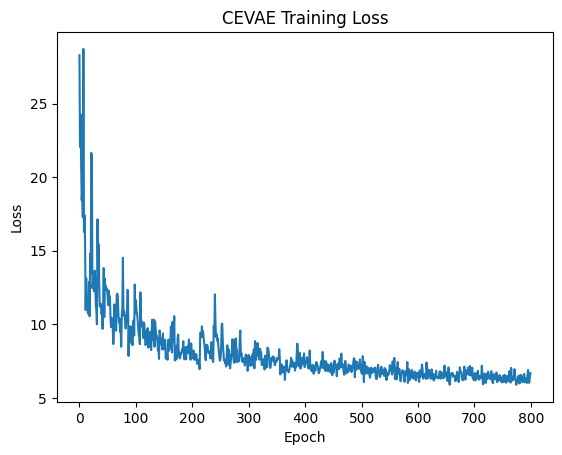

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.796194


Estimated (test) ATE: 0.7962
True ATE: 1.0000


In [15]:
# before every training run
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

losses = cevae.fit(
    x_train, t_train, y_train,
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    # learning_rate_decay=0.1,
    # weight_decay=1e-6
    )

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

# Estimate ITEs and ATE
ite = cevae.ite(x_test)
ate = ite.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

#### <a id='toc2_3_2_5_'></a>[Internal Representation](#toc0_)

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pyro import poutine

@torch.no_grad()
def plot_predicted_vs_true(cevae, x_test, num_samples=100):
    """
    Plot predicted outcomes vs true functions - linear case
    """
    # Get z values and predicted outcomes
    x = cevae.whiten(x_test)
    
    with pyro.plate("num_particles", num_samples, dim=-2):
        with poutine.trace() as tr, poutine.block(hide=["y", "t"]):
            cevae.guide(x)
        
        z = tr.trace.nodes["z"]["value"]  # [num_samples, batch_size, latent_dim]
        
        with poutine.do(data=dict(t=torch.zeros(()))):
            y0_pred = poutine.replay(cevae.model.y_mean, tr.trace)(x)
        
        with poutine.do(data=dict(t=torch.ones(()))):
            y1_pred = poutine.replay(cevae.model.y_mean, tr.trace)(x)
    
    # Flatten for plotting
    z_flat = z.reshape(-1, z.shape[-1])
    y0_pred_flat = y0_pred.reshape(-1)
    y1_pred_flat = y1_pred.reshape(-1)
    
    # Use first dimension of z if multi-dimensional
    z_plot = z_flat[:, 0] if z_flat.shape[1] > 0 else z_flat
    
    # Sort by z values
    sorted_indices = torch.argsort(z_plot)
    z_sorted = z_plot[sorted_indices]
    y0_pred_sorted = y0_pred_flat[sorted_indices]
    y1_pred_sorted = y1_pred_flat[sorted_indices]
    
    # Calculate true functions for LINEAR case
    gamma_true = -1.0 # IMPORTANT: This can be modified based on change-of-sign problem {+1,-1}
    tau_true = 1.0 
    y0_true = gamma_true * z_sorted                    # Y0 = gamma * z = z
    y1_true = gamma_true * z_sorted + tau_true         # Y1 = gamma * z + tau = z + 1
    tau_true_constant = torch.full_like(z_sorted, tau_true)  # Constant ITE = 1
    
    return z_sorted, y0_pred_sorted, y1_pred_sorted, y0_true, y1_true, tau_true_constant

# Get the data
z_sorted, y0_pred, y1_pred, y0_true, y1_true, tau_true = plot_predicted_vs_true(cevae, x_test)

# Create the plots - only first horizontal line
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Y0 (Control outcomes)
axes[0].scatter(z_sorted.cpu(), y0_pred.cpu(), alpha=0.4, s=10, color='lightblue', label='CEVAE Predicted')
axes[0].plot(z_sorted.cpu(), y0_true.cpu(), 'b-', linewidth=3, label='True: γz = z')  # Updated label
axes[0].set_xlabel('Z values (latent confounder)')
axes[0].set_ylabel('Y0 (Control Outcome)')
axes[0].set_title('Control Outcomes: Predicted vs True (Linear)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Y1 (Treatment outcomes)
axes[1].scatter(z_sorted.cpu(), y1_pred.cpu(), alpha=0.4, s=10, color='lightcoral', label='CEVAE Predicted')
axes[1].plot(z_sorted.cpu(), y1_true.cpu(), 'r-', linewidth=3, label='True: γz + τ = z + 1')  # Updated label
axes[1].set_xlabel('Z values (latent confounder)')
axes[1].set_ylabel('Y1 (Treatment Outcome)')
axes[1].set_title('Treatment Outcomes: Predicted vs True (Linear)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### <a id='toc2_3_3_'></a>[ITE results Linear Dataset](#toc0_)

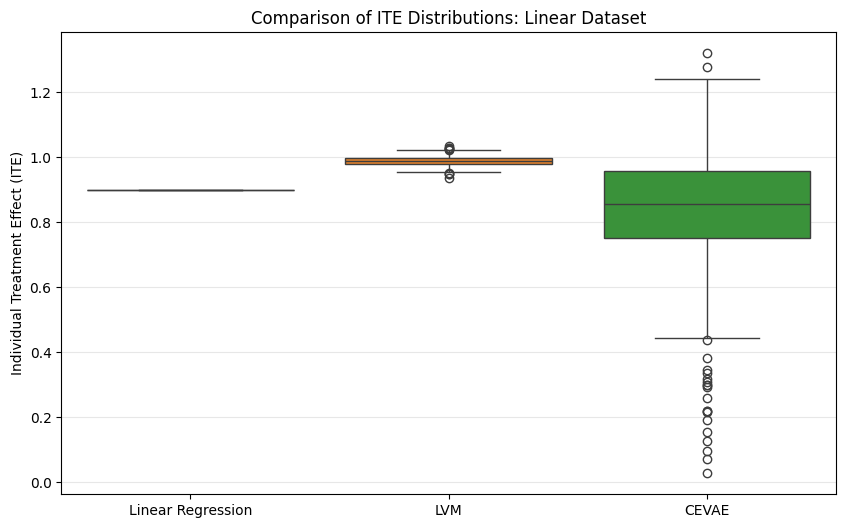

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=[
        ite_linear_model.flatten().cpu().numpy(),
        ite_pgm.flatten().cpu().numpy(),
        ite.flatten().cpu().numpy()
    ]
)
plt.xticks([0, 1, 2], ["Linear Regression", "LVM", "CEVAE"])
plt.ylabel("Individual Treatment Effect (ITE)")
plt.title("Comparison of ITE Distributions: Linear Dataset")
plt.grid(axis='y', alpha=0.3)
plt.show()

### <a id='toc2_3_3_'></a>[ITE results Non Linear Dataset](#toc0_)

In [48]:
non_linear_data = synthetic_dataset_non_linear(n=1000, beta=2.0, num_proxies=10, prior_type='gaussian', seed=0)

x, t, y, z, ite   = (
    non_linear_data["x"],
    non_linear_data["t"],
    non_linear_data["y"],
    non_linear_data["z"],
    non_linear_data["ite"]
    )

length_x  = x.shape[1]

In [49]:

# ----------------------------- train-test split ----------------------------- #

x_train, x_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(
    x, t, y, ite, test_size=0.2, random_state=0
)

In [50]:
linear_model = LinearModel()
linear_model.fit(x_train, t_train, y_train)          

ite_linear_model_nld = linear_model.ite(x_test)         
ate_linear_model_nld = ite_linear_model_nld.mean().item()
print("Average Treatment Effect (ATE):", ate_linear_model_nld)

Average Treatment Effect (ATE): 1.4702391624450684


In [51]:
pgm = PyroLinearProxyModel(init_scale=0.1, learning_rate=5e-3, weight_decay=0.0)
pyro.clear_param_store()

losses_pgm = pgm.fit(x_train, t_train, y_train, num_epochs=1000, log_every=100, posterior_epochs=1000)          

ite_pgm_nld = pgm.ite(x_test)         
ate_pgm_nld = ite_pgm_nld.mean().item()
# Compute mean squared error between true ITE and computed ITE
true_ite_nld = ite_test
# mse_pgm_nld = torch.mean((ite_pgm_nld.flatten() - true_ite.flatten()) ** 2).item()

print("Results for training data")
print("Average Treatment Effect (ATE) (through ITE)", ate_pgm_nld)
print("Estimated ATE fro model coefficients (by def):", pgm.estimate_ate())
# print("Mean Squared Error between true ITE and computed ITE:", mse_pgm_nld)
# print(ite)

[SVI] epoch  100 ELBO = 15122.95
[SVI] epoch  200 ELBO = 13873.12
[SVI] epoch  300 ELBO = 13692.28
[SVI] epoch  400 ELBO = 13624.66
[SVI] epoch  500 ELBO = 13608.80
[SVI] epoch  600 ELBO = 13590.29
[SVI] epoch  700 ELBO = 13591.95
[SVI] epoch  800 ELBO = 13584.22
[SVI] epoch  900 ELBO = 13578.69
[SVI] epoch 1000 ELBO = 13583.66
[SVI-xt] epoch  101 ELBO = 13450.46
[SVI-xt] epoch  201 ELBO = 12822.04
[SVI-xt] epoch  301 ELBO = 12524.19
[SVI-xt] epoch  401 ELBO = 12354.66
[SVI-xt] epoch  501 ELBO = 12299.49
[SVI-xt] epoch  601 ELBO = 12290.96
[SVI-xt] epoch  701 ELBO = 12287.74
[SVI-xt] epoch  801 ELBO = 12283.07
[SVI-xt] epoch  901 ELBO = 12284.15
Results for training data
Average Treatment Effect (ATE) (through ITE) 1.3035151958465576
Estimated ATE fro model coefficients (by def): 1.1586772203445435


INFO 	 Training with 8 minibatches per epoch


DEBUG 	 step     0 loss = 29.0854
DEBUG 	 step   100 loss = 18.0911
DEBUG 	 step   200 loss = 17.9008
DEBUG 	 step   300 loss = 18.2911
DEBUG 	 step   400 loss = 18.3719
DEBUG 	 step   500 loss = 17.5445
DEBUG 	 step   600 loss = 17.5143
DEBUG 	 step   700 loss = 17.8571


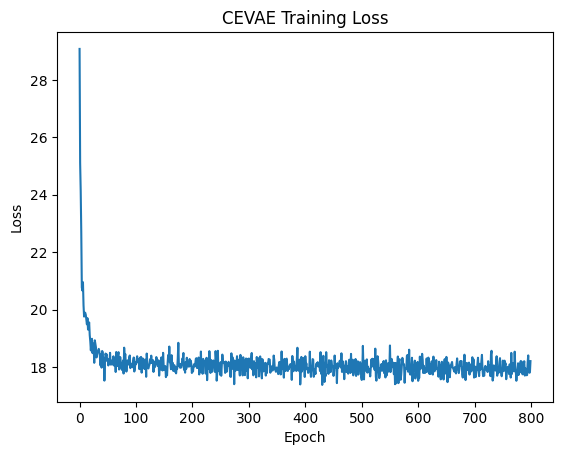

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.41219


Estimated (test) ATE: 1.4122
True ATE: 1.0145


In [52]:
# before every training run:
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

losses = cevae.fit(
    x_train, t_train, y_train,
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-4,
    learning_rate_decay=0.1,
    weight_decay=1e-6
    )

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

# Estimate ITEs and ATE
ite_cevae_nld = cevae.ite(x_test)
ate_cevae_nld = ite_cevae_nld.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate_cevae_nld:.4f}")
print(f"True ATE: {non_linear_data['ite'].mean().item():.4f}")

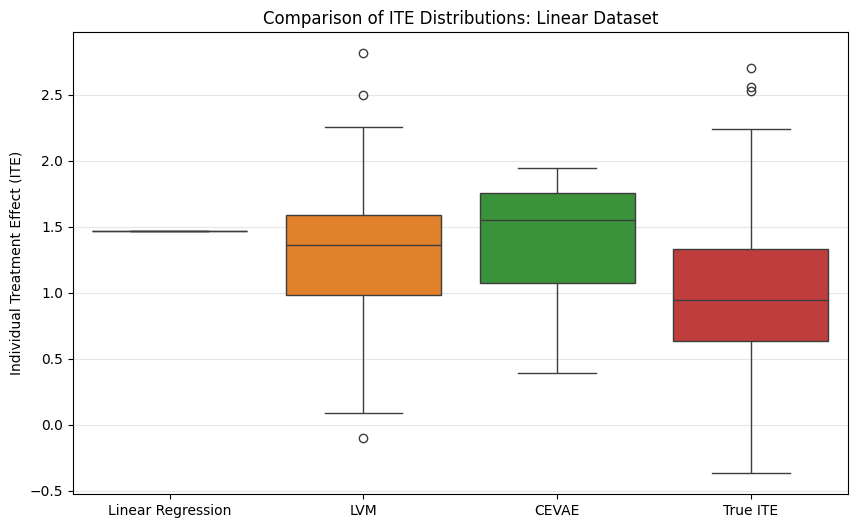

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=[
        ite_linear_model_nld.flatten().cpu().numpy(),
        ite_pgm_nld.flatten().cpu().detach().numpy(),
        ite_cevae_nld.flatten().cpu().numpy(),
        true_ite_nld.flatten().cpu().numpy()
    ]
)
plt.xticks([0, 1, 2, 3], ["Linear Regression", "LVM", "CEVAE", "True ITE"])
plt.ylabel("Individual Treatment Effect (ITE)")
plt.title("Comparison of ITE Distributions: Linear Dataset")
plt.grid(axis='y', alpha=0.3)
plt.show()

#### Internal Representation

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pyro import poutine

@torch.no_grad()
def plot_predicted_vs_true(cevae, x_test, num_samples=100):
    """
    Plot predicted outcomes vs true functions - first row only
    """
    # Get z values and predicted outcomes
    x = cevae.whiten(x_test)
    
    with pyro.plate("num_particles", num_samples, dim=-2):
        with poutine.trace() as tr, poutine.block(hide=["y", "t"]):
            cevae.guide(x)
        
        z = tr.trace.nodes["z"]["value"]  # [num_samples, batch_size, latent_dim]
        
        with poutine.do(data=dict(t=torch.zeros(()))):
            y0_pred = poutine.replay(cevae.model.y_mean, tr.trace)(x)
        
        with poutine.do(data=dict(t=torch.ones(()))):
            y1_pred = poutine.replay(cevae.model.y_mean, tr.trace)(x)
    
    # Flatten for plotting
    z_flat = z.reshape(-1, z.shape[-1])
    y0_pred_flat = y0_pred.reshape(-1)
    y1_pred_flat = y1_pred.reshape(-1)
    
    # Use first dimension of z if multi-dimensional
    z_plot = z_flat[:, 0] if z_flat.shape[1] > 0 else z_flat
    
    # Sort by z values
    sorted_indices = torch.argsort(z_plot)
    z_sorted = z_plot[sorted_indices]
    y0_pred_sorted = y0_pred_flat[sorted_indices]
    y1_pred_sorted = y1_pred_flat[sorted_indices]
    
    # Calculate true functions
    g_true = torch.sin(z_sorted) + 0.5 * z_sorted  # Control outcome
    tau_true = 1.0 + 0.5 * z_sorted  # Treatment effect
    y1_true = g_true + tau_true  # Treatment outcome
    
    return z_sorted, y0_pred_sorted, y1_pred_sorted, g_true, y1_true, tau_true

# Get the data
z_sorted, y0_pred, y1_pred, y0_true, y1_true, tau_true = plot_predicted_vs_true(cevae, x_test)

# Create the plots - only first horizontal line
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Y0 (Control outcomes)
axes[0].scatter(z_sorted.cpu(), y0_pred.cpu(), alpha=0.4, s=10, color='lightblue', label='CEVAE Predicted')
axes[0].plot(z_sorted.cpu(), y0_true.cpu(), 'b-', linewidth=3, label='True: sin(z) + 0.5z')
axes[0].set_xlabel('Z values (latent confounder)')
axes[0].set_ylabel('Y0 (Control Outcome)')
axes[0].set_title('Control Outcomes: Predicted vs True')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Y1 (Treatment outcomes)
axes[1].scatter(z_sorted.cpu(), y1_pred.cpu(), alpha=0.4, s=10, color='lightcoral', label='CEVAE Predicted')
axes[1].plot(z_sorted.cpu(), y1_true.cpu(), 'r-', linewidth=3, label='True: sin(z) + z + 1')
axes[1].set_xlabel('Z values (latent confounder)')
axes[1].set_ylabel('Y1 (Treatment Outcome)')
axes[1].set_title('Treatment Outcomes: Predicted vs True')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# <a id='toc3_'></a>[Experiments](#toc0_)

### <a id='toc3_1_1_'></a>[Setting parameters defaults](#toc0_)

In [3]:
num_proxies = 10
n_data = 500

data_defaults_non_lin = dict(
    n=n_data,
    num_proxies=num_proxies,
    sigma_x=1.0,
    sigma_y=1.0,
    prior_type="gaussian",
    seed=0,
)

data_defaults_linear = dict(
    n=n_data,
    beta=1.0,
    num_proxies=num_proxies,
    shuffle_pct=0.0,
    sigma_x=1.0,
    sigma_y=1.0,
    seed=0,
)

model_defaults = dict(
    feature_dim=num_proxies,
    latent_dim=1,
    num_layers=3,   # number of hidden layers
    hidden_dim=200,  # number of hidden units in each layer
    outcome_dist="normal",
)

fit_defaults = dict(
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    weight_decay=0.0,
    log_every=0,
)

pgm_fit_defaults = dict(
    num_epochs=1000,
    posterior_epochs=1000,
    batch_size=100,  # ignored here, we do full-batch
    learning_rate=5e-3,
    weight_decay=0.0,
    log_every=100,
)

metrics = {
    "abs_ate_err": rel_ate_error,
    "rmse_ite": rmse_ite,
}

#### <a id='toc3_1_1_1_'></a>[Choosing the dataset](#toc0_)

In [4]:
# dataset_type = "linear"  # or "non_linear"

# if dataset_type == "non_linear":
#     data_gen_fn = synthetic_dataset_non_linear
#     data_defaults = data_defaults_non_lin
# elif dataset_type == "linear":

data_gen_fn = synthetic_dataset_linear
data_defaults = data_defaults_linear

### <a id='toc3_1_2_'></a>[E1: increasing sample size](#toc0_)

In [ ]:
# set up params to sweep
param_grid = {
    "data__n": np.linspace(500,2000,10, dtype=int),
}
pyro.clear_param_store()

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)
pyro.clear_param_store()

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 5801.31
[SVI] epoch  200 ELBO = 3868.21
[SVI] epoch  300 ELBO = 2854.79
[SVI] epoch  400 ELBO = 2373.83
[SVI] epoch  500 ELBO = 2089.62
[SVI] epoch  600 ELBO = 1929.24
[SVI] epoch  700 ELBO = 1802.03
[SVI] epoch  800 ELBO = 1743.33
[SVI] epoch  900 ELBO = 1700.04
[SVI] epoch 1000 ELBO = 1667.24
[SVI-xt] epoch  101 ELBO = 3011.80
[SVI-xt] epoch  201 ELBO = 2263.74
[SVI-xt] epoch  301 ELBO = 1889.37
[SVI-xt] epoch  401 ELBO = 1736.16
[SVI-xt] epoch  501 ELBO = 1620.76
[SVI-xt] epoch  601 ELBO = 1591.28
[SVI-xt] epoch  701 ELBO = 1559.89
[SVI-xt] epoch  801 ELBO = 1540.64
[SVI-xt] epoch  901 ELBO = 1537.65
[SVI] epoch  100 ELBO = 18356.79
[SVI] epoch  200 ELBO = 11659.53
[SVI] epoch  300 ELBO = 8037.45
[SVI] epoch  400 ELBO = 6032.14
[SVI] epoch  500 ELBO = 5054.76
[SVI] epoch  600 ELBO = 4361.61
[SVI] epoch  700 ELBO = 4027.27
[SVI] epoch  800 ELBO = 3813.07
[SVI] epoch  900 ELBO = 3705.06
[SVI] epoch 1000 ELBO = 3601.76
[SVI-xt] epoch  101 ELBO = 7481.90
[SVI-xt]

INFO 	 Training with 1 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.785077
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.783556
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.06389
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.062
INFO 	 Training with 3 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.42407
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.42646
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.813755
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.812128
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742853
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742378
INFO 	 Training with 5 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.09135
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.09095
INFO 	

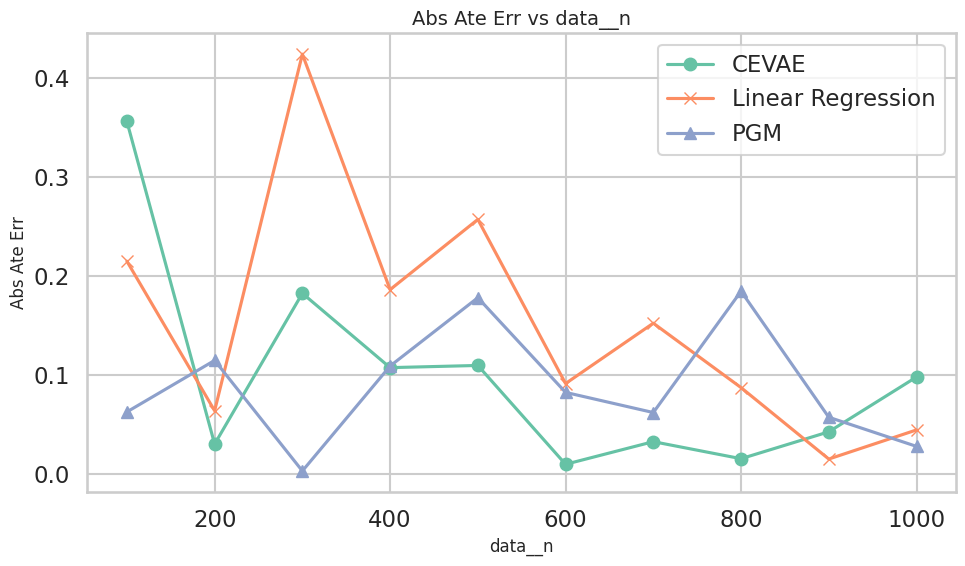

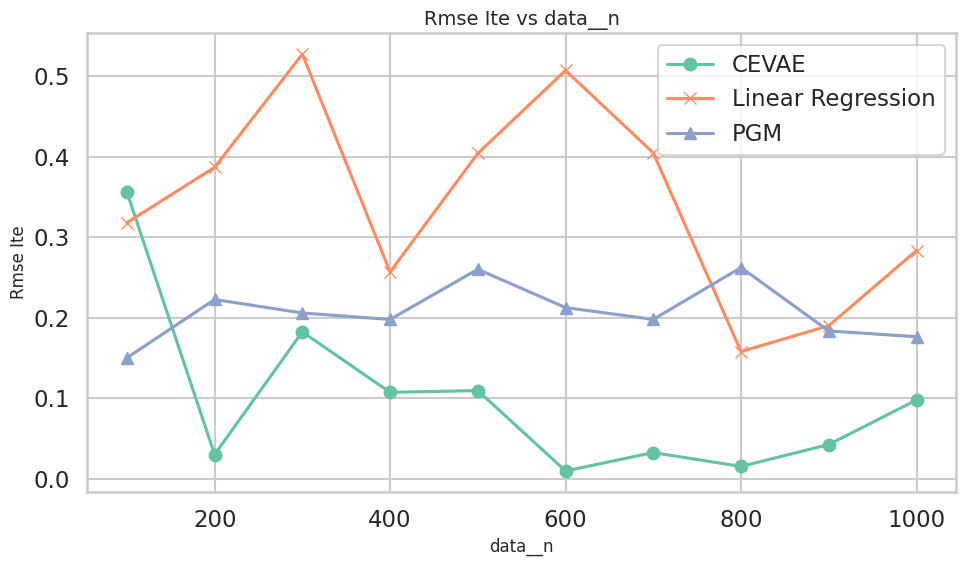

In [62]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__n")

### <a id='toc3_1_3_'></a>[E2: increasing correlation among proxies (not through $Z$)](#toc0_)

In [ ]:
# set up params to sweep
param_grid = {
    "data__rho": np.linspace(0.0, 0.9, 10),
}
pyro.clear_param_store()

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)
pyro.clear_param_store()

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 26184.39
[SVI] epoch  200 ELBO = 17274.07
[SVI] epoch  300 ELBO = 12860.57
[SVI] epoch  400 ELBO = 10750.25
[SVI] epoch  500 ELBO = 9674.49
[SVI] epoch  600 ELBO = 9137.00
[SVI] epoch  700 ELBO = 8730.33
[SVI] epoch  800 ELBO = 8554.65
[SVI] epoch  900 ELBO = 8410.46
[SVI] epoch 1000 ELBO = 8271.71
[SVI-xt] epoch  101 ELBO = 13699.87
[SVI-xt] epoch  201 ELBO = 10294.40
[SVI-xt] epoch  301 ELBO = 8899.00
[SVI-xt] epoch  401 ELBO = 8247.20
[SVI-xt] epoch  501 ELBO = 7948.70
[SVI-xt] epoch  601 ELBO = 7775.04
[SVI-xt] epoch  701 ELBO = 7686.55
[SVI-xt] epoch  801 ELBO = 7648.41
[SVI-xt] epoch  901 ELBO = 7623.74
[SVI] epoch  100 ELBO = 26240.01
[SVI] epoch  200 ELBO = 17309.52
[SVI] epoch  300 ELBO = 12886.32
[SVI] epoch  400 ELBO = 10771.15
[SVI] epoch  500 ELBO = 9691.70
[SVI] epoch  600 ELBO = 9154.07
[SVI] epoch  700 ELBO = 8748.52
[SVI] epoch  800 ELBO = 8574.47
[SVI] epoch  900 ELBO = 8433.47
[SVI] epoch 1000 ELBO = 8296.85
[SVI-xt] epoch  101 ELBO = 13688.25

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742853
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742378
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.686796
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.686071
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.782449
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.782647
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.596868
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.596401
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.802972
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.802778
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.693901
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.69231

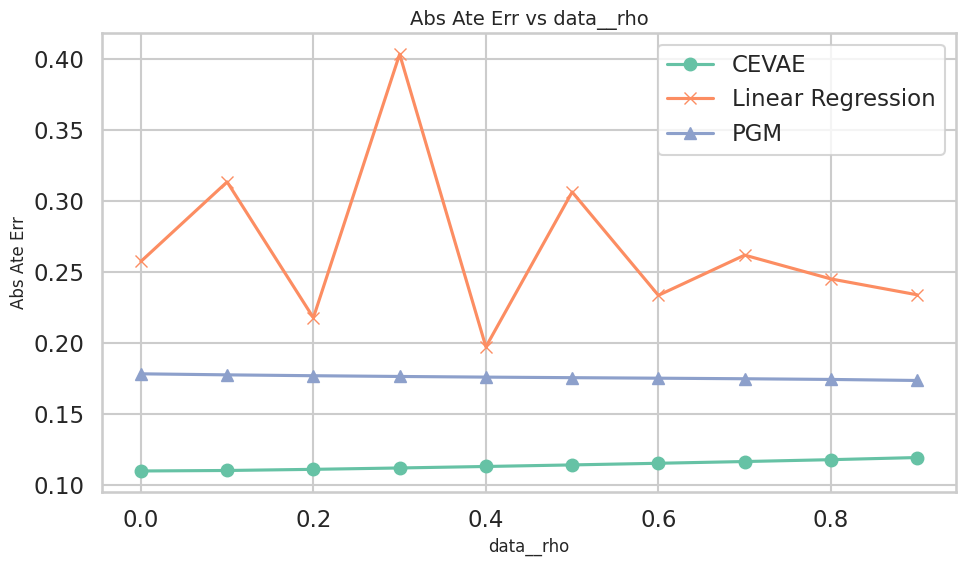

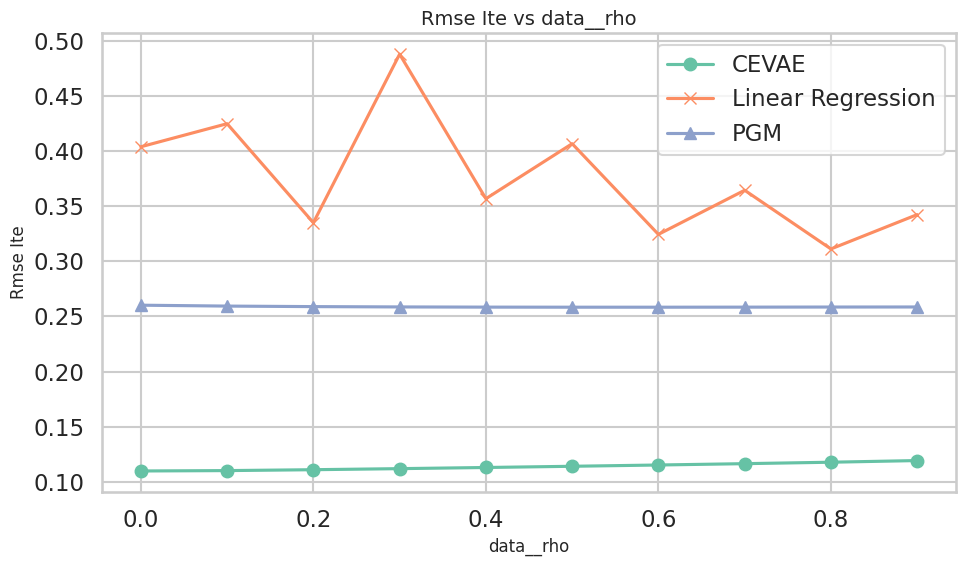

In [5]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__rho")

### <a id='toc3_1_4_'></a>[E3: increasing decorellation among proxies (through shuffling)](#toc0_)

In [6]:
# set up params to sweep
param_grid = {
    "data__shuffle_pct": np.linspace(0.0, 1.0, 11)
}
pyro.clear_param_store()

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)
pyro.clear_param_store()

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 26184.39
[SVI] epoch  200 ELBO = 17274.07
[SVI] epoch  300 ELBO = 12860.57
[SVI] epoch  400 ELBO = 10750.25
[SVI] epoch  500 ELBO = 9674.49
[SVI] epoch  600 ELBO = 9137.00
[SVI] epoch  700 ELBO = 8730.33
[SVI] epoch  800 ELBO = 8554.65
[SVI] epoch  900 ELBO = 8410.46
[SVI] epoch 1000 ELBO = 8271.71
[SVI-xt] epoch  101 ELBO = 13699.87
[SVI-xt] epoch  201 ELBO = 10294.40
[SVI-xt] epoch  301 ELBO = 8899.00
[SVI-xt] epoch  401 ELBO = 8247.20
[SVI-xt] epoch  501 ELBO = 7948.70
[SVI-xt] epoch  601 ELBO = 7775.04
[SVI-xt] epoch  701 ELBO = 7686.55
[SVI-xt] epoch  801 ELBO = 7648.41
[SVI-xt] epoch  901 ELBO = 7623.74
[SVI] epoch  100 ELBO = 26318.36
[SVI] epoch  200 ELBO = 17815.32
[SVI] epoch  300 ELBO = 13652.03
[SVI] epoch  400 ELBO = 11639.78
[SVI] epoch  500 ELBO = 10569.84
[SVI] epoch  600 ELBO = 9956.69
[SVI] epoch  700 ELBO = 9588.30
[SVI] epoch  800 ELBO = 9310.17
[SVI] epoch  900 ELBO = 9142.73
[SVI] epoch 1000 ELBO = 8991.04
[SVI-xt] epoch  101 ELBO = 13793.5

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742853
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742378
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.871882
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.870119
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.968266
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.9689
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.28801
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.28895
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.764063
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.763355
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.08032
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.07723
INFO

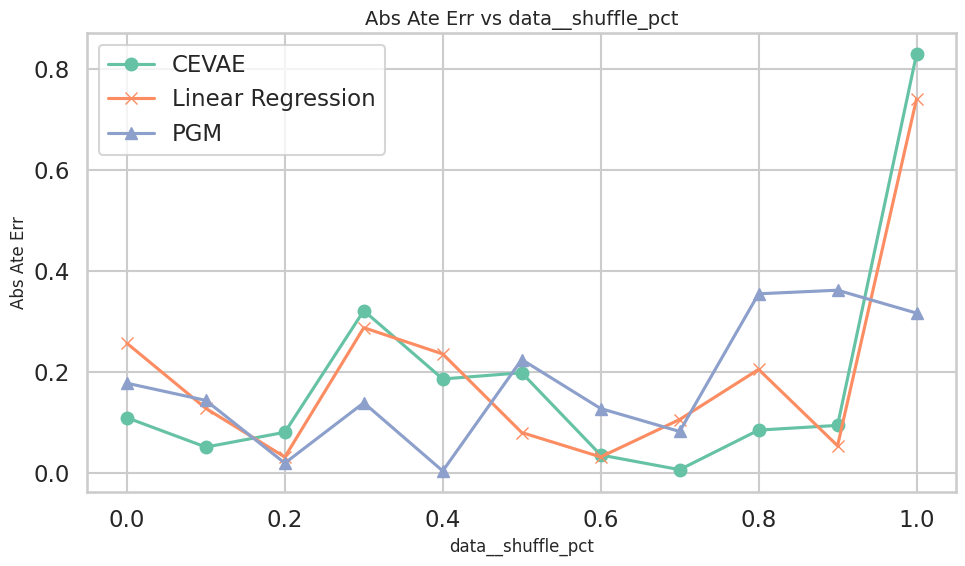

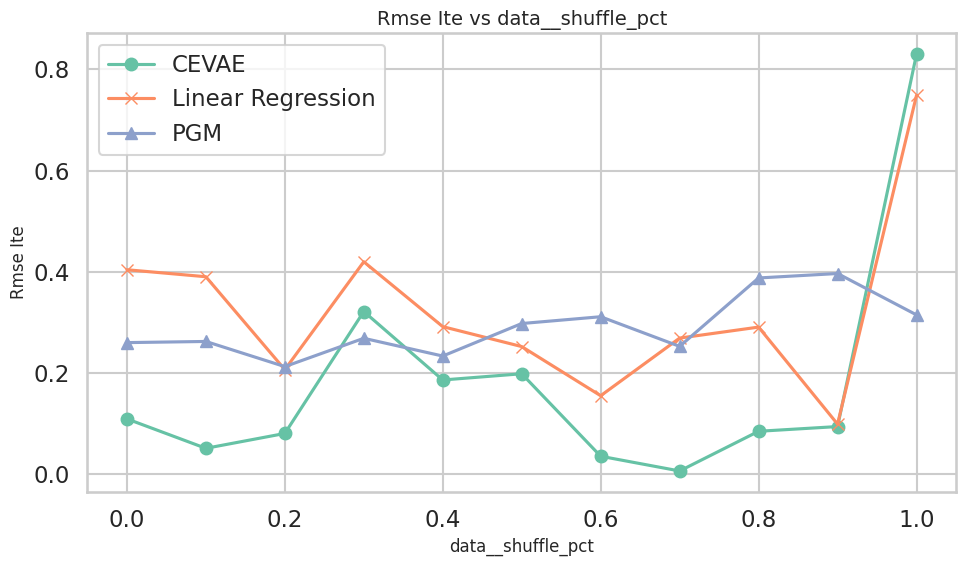

In [7]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__shuffle_pct")

### <a id='toc3_1_5_'></a>[E4: increasing the latent dimension (of the CEVAE)](#toc0_)

In [8]:
# set up params to sweep
param_grid = {
    "model__latent_dim": [1, 2, 5, 10, 20],
}

# run the experiment
res = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.632827
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.639507
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.448697
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.454603
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.681714
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.68467
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.655898
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.644613
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.732971
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.736479


In [9]:
def plot_cevae_results(cevae_res, x_param="data__shuffle_pct", palette_name="Set2"):
    """
    Plot results for the CEVAE model for each metric on individual plots,
    using a nicer seaborn color palette.
    """
    # set up seaborn styling
    sns.set_style("whitegrid")
    sns.set_context("talk")  # makes labels/text a bit larger

    # find all metric columns (exclude x axis and any unwanted columns)
    metrics = [c for c in cevae_res.columns if c not in (x_param, "final_elbo")]

    # grab a single color from the specified palette
    color = sns.color_palette(palette_name, n_colors=1)[0]

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        plt.plot(
            cevae_res[x_param],
            cevae_res[metric],
            marker="o",
            label="CEVAE",
            color=color
        )

        plt.xlabel(x_param, fontsize=12)
        plt.ylabel(metric.replace('_', ' ').title(), fontsize=12)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param} (CEVAE)", fontsize=14)
        plt.legend(frameon=True)
        plt.tight_layout()
        plt.show()


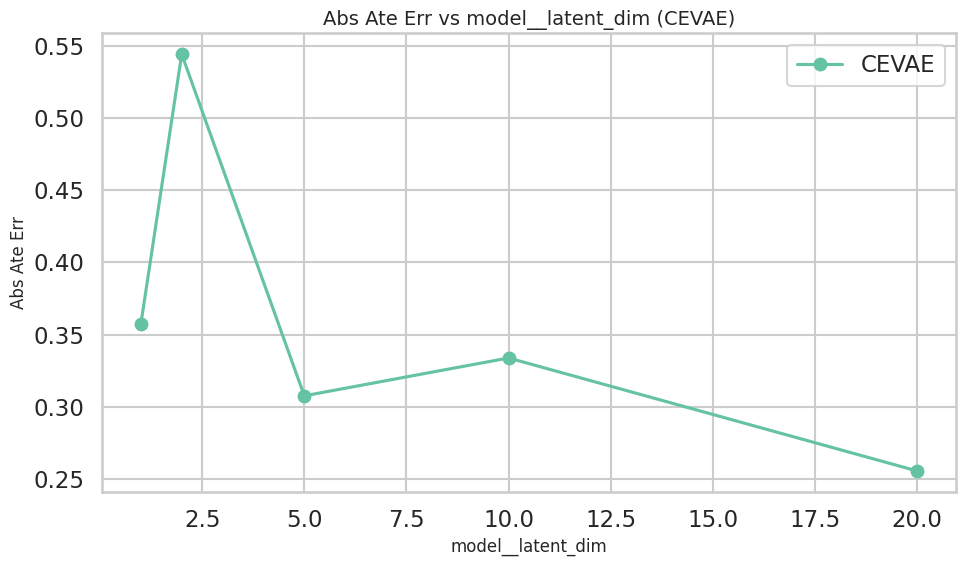

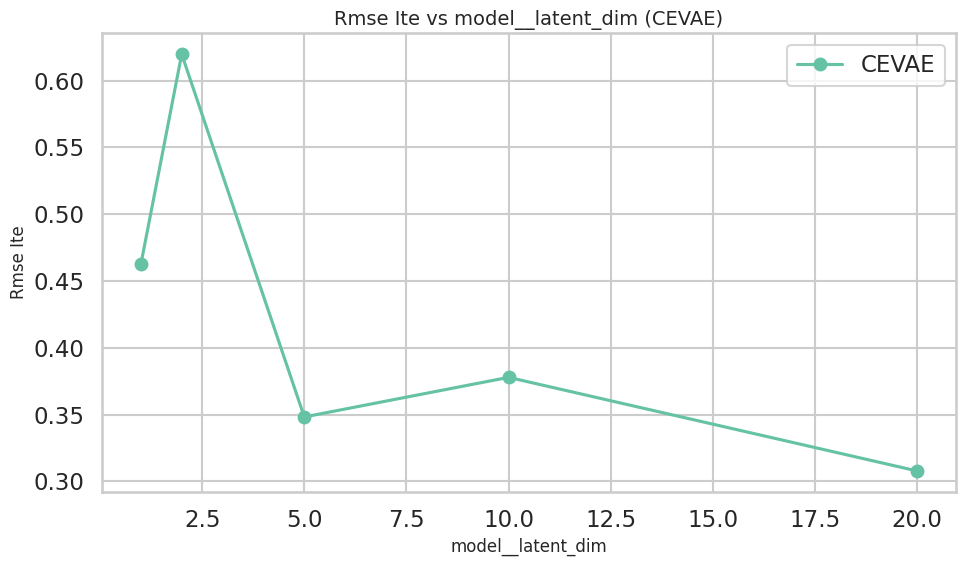

In [13]:
plot_cevae_results(res, x_param="model__latent_dim", palette_name="Set2")

### <a id='toc3_1_6_'></a>[E5: prior misspecification](#toc0_)

In [4]:
# set up params to sweep
param_grid = {
    "data__prior_type": ["gaussian", "bimodal", "lognormal"],  # type of prior distribution
}

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 26184.39
[SVI] epoch  200 ELBO = 17274.07
[SVI] epoch  300 ELBO = 12860.57
[SVI] epoch  400 ELBO = 10750.25
[SVI] epoch  500 ELBO = 9674.49
[SVI] epoch  600 ELBO = 9137.00
[SVI] epoch  700 ELBO = 8730.33
[SVI] epoch  800 ELBO = 8554.65
[SVI] epoch  900 ELBO = 8410.46
[SVI] epoch 1000 ELBO = 8271.71
[SVI-xt] epoch  101 ELBO = 13699.87
[SVI-xt] epoch  201 ELBO = 10294.40
[SVI-xt] epoch  301 ELBO = 8899.00
[SVI-xt] epoch  401 ELBO = 8247.20
[SVI-xt] epoch  501 ELBO = 7948.70
[SVI-xt] epoch  601 ELBO = 7775.04
[SVI-xt] epoch  701 ELBO = 7686.55
[SVI-xt] epoch  801 ELBO = 7648.41
[SVI-xt] epoch  901 ELBO = 7623.74
[SVI] epoch  100 ELBO = 504565.03
[SVI] epoch  200 ELBO = 321765.13
[SVI] epoch  300 ELBO = 221202.02
[SVI] epoch  400 ELBO = 156608.99
[SVI] epoch  500 ELBO = 111726.40
[SVI] epoch  600 ELBO = 80969.36
[SVI] epoch  700 ELBO = 59181.41
[SVI] epoch  800 ELBO = 44142.62
[SVI] epoch  900 ELBO = 33830.23
[SVI] epoch 1000 ELBO = 26967.69
[SVI-xt] epoch  101 ELBO

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742853
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742378
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.360131
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.351717
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.717231
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.717264


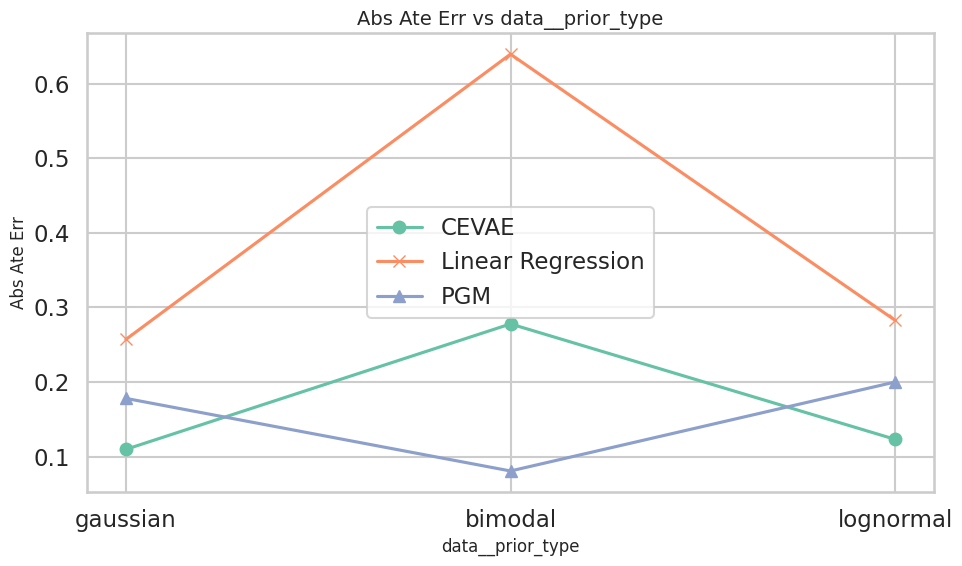

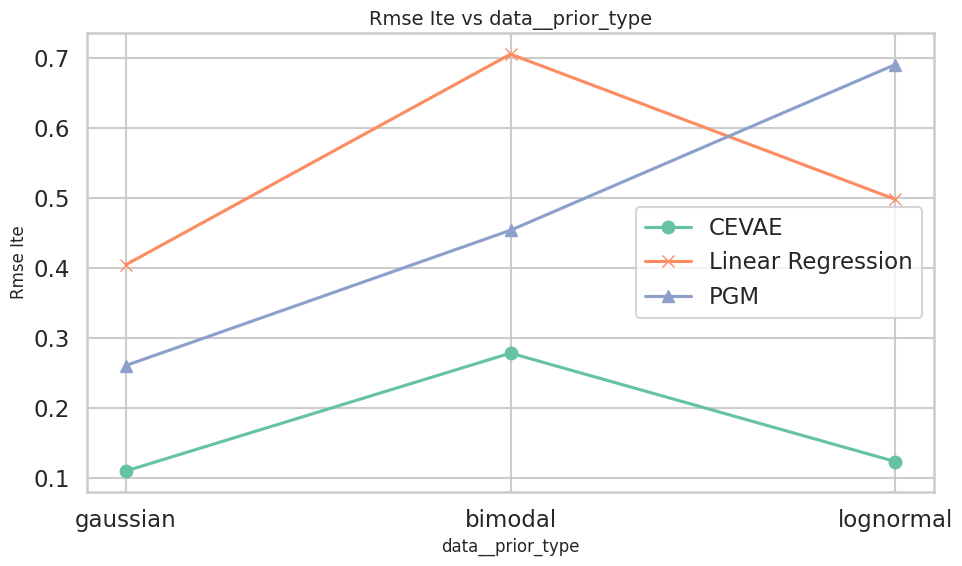

In [5]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__prior_type")

### E8: increasing the number of proxies

In [5]:
# set up params to sweep
param_grid = {
    "data__num_proxies": np.linspace(10,50,10, dtype=int),  # number of proxy variables
}

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)


results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742853
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.742378
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.849511
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.849405
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.05846
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.05812
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.07741
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.07767
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.25212
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.25244
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.95668
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.955405
INFO 

[SVI] epoch  100 ELBO = 26184.39
[SVI] epoch  200 ELBO = 17274.07
[SVI] epoch  300 ELBO = 12860.57
[SVI] epoch  400 ELBO = 10750.25
[SVI] epoch  500 ELBO = 9674.49
[SVI] epoch  600 ELBO = 9137.00
[SVI] epoch  700 ELBO = 8730.33
[SVI] epoch  800 ELBO = 8554.65
[SVI] epoch  900 ELBO = 8410.46
[SVI] epoch 1000 ELBO = 8271.71
[SVI-xt] epoch  101 ELBO = 13699.87
[SVI-xt] epoch  201 ELBO = 10294.40
[SVI-xt] epoch  301 ELBO = 8899.00
[SVI-xt] epoch  401 ELBO = 8247.20
[SVI-xt] epoch  501 ELBO = 7948.70
[SVI-xt] epoch  601 ELBO = 7775.04
[SVI-xt] epoch  701 ELBO = 7686.55
[SVI-xt] epoch  801 ELBO = 7648.41
[SVI-xt] epoch  901 ELBO = 7623.74
[SVI] epoch  100 ELBO = 39263.54
[SVI] epoch  200 ELBO = 25618.48
[SVI] epoch  300 ELBO = 18663.20
[SVI] epoch  400 ELBO = 15198.27
[SVI] epoch  500 ELBO = 13370.39
[SVI] epoch  600 ELBO = 12416.71
[SVI] epoch  700 ELBO = 11802.77
[SVI] epoch  800 ELBO = 11403.08
[SVI] epoch  900 ELBO = 11147.55
[SVI] epoch 1000 ELBO = 10951.76
[SVI-xt] epoch  101 ELBO = 19

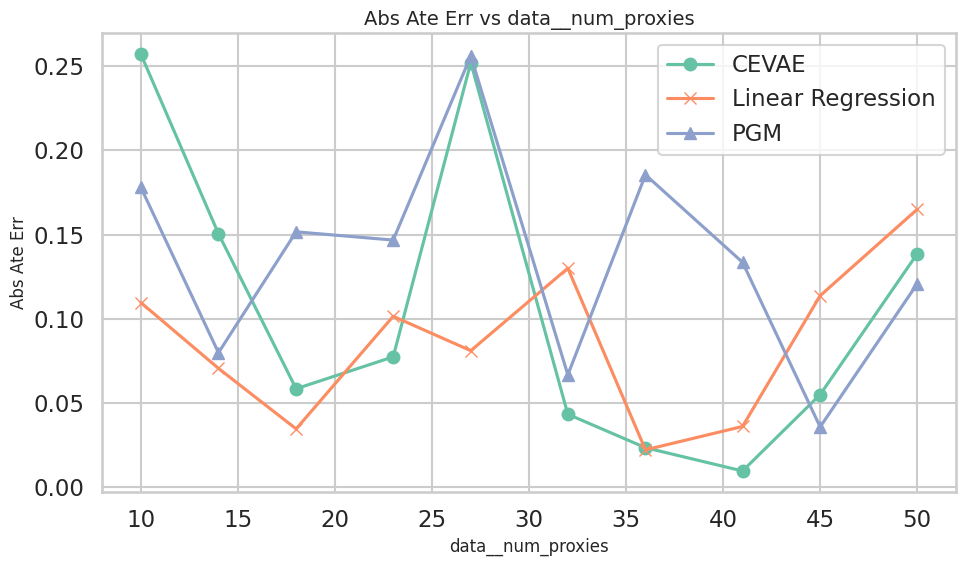

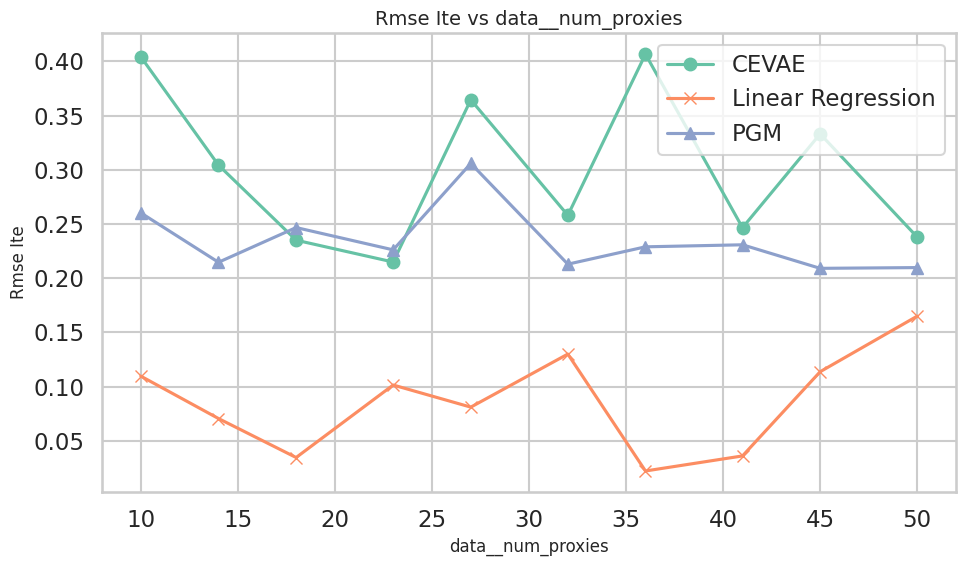

In [6]:
plot_three_experiment_results(results_cevae,results_lr,results_pgm, x_param="data__num_proxies")